Notebook to replicate our results for data set 2 which uses a RNN for condition procession

In [1]:
import copy
import torch.nn as nn
import torch
from FrEIA.framework import *
from FrEIA.modules import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
device = torch.device("cuda:0")
pad = lambda x: nn.utils.rnn.pad_sequence(x, batch_first = True).to(device)
pack = lambda x, y: nn.utils.rnn.pack_padded_sequence(x, y, batch_first=True, enforce_sorted=False)

In [2]:
def load_data():
    """
    Helper function to read the data which is saved in multiple .csv files
    converts data to pytorch tensors
    """
    all_data = []
    all_params = []
    all_length = []
    i = 0
    j = 0
    while(True):
        name_dat = f"./data_mobility{j}/dat{i}.csv"
        name_param = f"./params_mobility{j}/params{i}.csv"
        try:
            df_dat = pd.read_csv(name_dat)
            df_param = pd.read_csv(name_param)
            param = df_param.to_numpy()[0,[0,1,10]]
            data = df_dat.iloc[:,2].to_numpy().reshape(-1,7)[:,[0,1,2,3]]
            if len(data[np.isnan(data)]) == 0:
                all_data.append(torch.from_numpy(data).to(torch.float32).to(device))
                all_params.append(param)
                all_length.append(len(data))
            else:
                print(i)
            i += 1
        except Exception as e:
            i = 0
            j += 1
            print("Loaded",len(all_data),"Entries")
        if j>8:
            print("not so much data")
            break
        if len(all_data)%1000 == 0:
            print("Loaded",len(all_data),"Entries")
    all_params = torch.from_numpy(np.array(all_params)).to(torch.float32).to(device)
    return all_data, all_params, all_length

data, params, length = load_data()
data_dict = {"data": data,
            "params": params,
            "length": length}

torch.save(data_dict, "data_second.save")

'\n# save the data in a torch file which is much faster to load then the .csvs\n\ndata, params, length = load_data()\ndata_dict = {"data": data,\n            "params": params,\n            "length": length}\n\ntorch.save(data_dict, "data_second.save")\n'

In [3]:
#data_dict = torch.load("data_second.save", map_location = device)

In [4]:
data = data_dict["data"][:290000]
padded_data = pad(data)
params = data_dict["params"][:290000]
length = data_dict["length"][:290000]
test_dat = data_dict["data"][290000:]
test_params = data_dict["params"][290000:]
test_length = data_dict["length"][290000:]

In [5]:
class preprocessor():
    """
    Used to save initial means and range of the parameters and
    applies the preprocessing
    
    """
    def __init__(self, params):
        self.means = params.mean(dim = 0)
        self.max = torch.abs(params-self.means).max(dim = 0)[0]+1e-5
 
    def __call__(self, params, fwd = True):
        if fwd:
            return torch.arctanh((params - self.means)/self.max)
        else:
            return torch.tanh(params) * self.max + self.means

prepper = preprocessor(params)
prepped = prepper(params, fwd = True)

In [6]:
class Decoder(nn.Module):
    """
    Decoder base class for use in an autoencoder
    N: amount of linear layers
    hidden_size: width of the hidden layers
    out_size: output dim of the decoder, should match the rnns input dim
    lr: learning rate
    """
    def __init__(self, N, inp_size, hidden_size, out_size, lr = 1e-3):
        super(Decoder, self).__init__()
        self.inp_size = inp_size
        self.linear = get_linear_subnet(N, inp_size, hidden_size, out_size)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.linear.parameters())) 
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of Decoder parameters: {n_trainable}", flush=True)        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.999],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )        
        
    def forward(self, x):
        return self.linear(x)

class AE():
    """
    Autoencoder class used to pretrain the RNN
    as decoder a simple fcnn is used
    rnn: object of type RNN which is trained
    N: amount of linear layers for the decoder
    hidden_size: width of the hidden decoder layers
    dim: output dim of the decoder, should match the rnns input dim
    """
    def __init__(self, rnn, N = 6, hidden_size = 256, dim = 4):
        self.dim = dim
        self.encoder = rnn
        self.decoder = Decoder(N, rnn.get_dim(), hidden_size, 149 * self.dim)
    def train(self, epochs, x, lengths, batch_size = 2048):
        loss_curve = []
        metrics_curve = []
        zeros = torch.zeros((batch_size,149,self.dim), dtype = torch.float32, device = device)
        for epoch in range(epochs):
            epoch_index = np.random.permutation(len(x))
            epoch_losses = 0
            for i in range(len(x)//batch_size):
                xsamps = x[epoch_index][i*batch_size:(i+1)*batch_size]
                length = lengths[epoch_index][i*batch_size:(i+1)*batch_size]
                
                packed_xsamps = pack(xsamps, length)
                
                self.decoder.optimizer.zero_grad(set_to_none=True)
                self.encoder.optimizer.zero_grad(set_to_none=True)
                encoded = self.encoder(packed_xsamps)
                decoded = self.decoder(encoded).view(-1,149,self.dim)
                
                difference = (torch.where(xsamps != 0, decoded, zeros)-xsamps)**2
                loss = torch.mean(difference)
                if loss < 1e30:
                    loss.backward()
                else:
                    print(f"loss is {loss}")
                    return
                self.encoder.optimizer.step()
                self.decoder.optimizer.step()
                epoch_losses += loss.item()/(len(x)//batch_size)
            loss_curve.append(epoch_losses)
            self.encoder.scheduler.step(epoch_losses)
            self.decoder.scheduler.step(epoch_losses)
            print("Epoch:", epoch + 1)
            print("Loss:", epoch_losses)
        self.decoder.optimizer.zero_grad(set_to_none=True)
        self.encoder.optimizer.zero_grad(set_to_none=True)
        plt.plot(np.arange(len(loss_curve)),np.array(loss_curve))      
        
    def inference(self, x):
        with torch.no_grad():
            decoded = self.decoder(self.encoder(x.view(1,-1,self.dim))).view(149,self.dim).cpu().numpy()
        xnump = x.cpu().numpy()
        fig, ax = plt.subplots(7, figsize = (8,16))
        names = ["Susceptible", "Infected", "Immune", "Dead", "Asymptomatic", "Hospitalized", "Severe"]
        for i in range(7):
            ax[i].plot(np.arange(len(xnump)), xnump[:,i], label = f"Truth")
            ax[i].plot(np.arange(149), decoded[:,i], label = f"Fake")
            ax[i].set_ylabel(names[i])
            
            ax[i].legend()
            ax[i].set_ylim([0,1])
        ax[3].set_xlabel("Time in days")
        plt.savefig("rnn.pdf")

In [7]:
def get_linear_subnet(N, inp_size, hidden_size, out_size):
    """
    Helper function to get linear network with ReLU activation
    N: amount of layers, not including the final linear output layer
    inp_size: dimension of the input
    hidden_size: width of the N-1 hidden layers
    out_size: dimension of the output
    """
    layer_list = []
    layer_list.append(nn.Linear(inp_size, hidden_size))
    layer_list.append(nn.ReLU())
    for i in range(N-1):
        layer_list.append(nn.Linear(hidden_size, hidden_size))
        layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(hidden_size, out_size))
    return nn.Sequential(*layer_list).to(device)

class RNN(nn.Module):
    """"
    RNN baseclass, used as conditioning network for the cINN. Implemented as an LSTM
    inp_size: dimension of the input timeseries
    hidden_size: parallel channels used by the rnns
    numm_rnns: amount of lstms
    lr: learning rate
    bi: wether to use bidirectional lstms or not
    """
    def __init__(self, inp_size, hidden_size = 5, num_rnns = 6, lr = 1e-3, bi = False):
        super(RNN, self).__init__()
        self.inp_size = inp_size
        self.rnn = nn.LSTM(inp_size, hidden_size, num_rnns, batch_first = True, bidirectional = bi).to(device)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.rnn.parameters())) 
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of RNN parameters: {n_trainable}", flush=True)        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.99],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )        
        
    def forward(self, x):
        full, (last, cn) = self.rnn(x)
        return torch.swapaxes(last, 0, 1).reshape(last.shape[1], -1)
    
    def get_dim(self):
        """
        passes dummy variable through network to get the outputs shape
        """
        return self.forward(torch.randn(1,100,self.inp_size, device = device)).shape[1]
        
    
class cINN(nn.Module):
    """
    cINN baseclass, using cubic spline blocks.
    inp_size: dimension of the input
    cond_size: dimension of the conditions
    num_blocks: amount of coupling blocks used
    sub_layers: amount of linear layers in the subnetworks
    sub_width: width of the subnetworks
    lr: learning rate, scheduler used is reduce_on_plateau
    """
    def __init__(self, inp_size, cond_size, num_blocks = 10, sub_layers = 3, sub_width = 256, lr = 2e-4):
        super(cINN, self).__init__()
        constructor_fct = lambda x_in, x_out: get_linear_subnet(sub_layers, 
                                                                x_in,
                                                                x_in,
                                                                x_out)

        block_kwargs = {
                        "num_bins": 120,
                        "subnet_constructor": constructor_fct,
                        "bounds_init": 5,
                        "permute_soft": False
                           }
        inp_size = (inp_size,)        
        nodes = [InputNode(*inp_size, name='inp')]
        cond_node = ConditionNode(*(cond_size,))
        for i in range(num_blocks):
            nodes.append(Node(
                    [nodes[-1].out0],
                    CubicSplineBlock,
                    block_kwargs,
                    conditions = cond_node,
                    name = f"block_{i}",
                    
                ))
        nodes.append(OutputNode([nodes[-1].out0], name='out'))
        nodes.append(cond_node)
        self.model = GraphINN(nodes, verbose=False).to(device)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.model.parameters()))
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of cINN parameters: {n_trainable}", flush=True)
        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.99],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )
    def forward(self, x, cond = None, rev = False):
        return self.model(x, c = cond, rev = rev)


class Estimator():
    """
    Wrapper for training cINN and RNN at the same time, also used for inference
    """
    def __init__(self, rnn, cinn):
        self.cinn = cinn
        self.rnn = rnn

    def metrik(self, true, data, zeros):
        """
        Used to measure the distance between truth and generated parameters
        Better interpretable than the Loss function
        """
        with torch.no_grad():
            cond = self.rnn(data)
            output, _ = self.cinn(zeros, cond, rev = True)
            output = torch.abs(prepper(output, fwd = False) - prepper(true, fwd = False))
            output = torch.mean(output, dim = 0).cpu().numpy()
        print("Metric:", output)
        return output
    
    def train(self, epochs, xtrain, ytrain, lengths, batch_size, train_rnn = True):
        """
        Trains the cINN and shows loss and metric plots
        epochs: amount of epochs to train
        xtrain: training parameters
        ytrain: corresponding time series, need to be zero padded
        lengths: real lengths of the time series, used for packing them again
        batch_size: Batch size used for the training
        train_rnn: Enable weight updates for the RNN
        """
        loss_curve = []
        metrics_curve = []
        zeros = torch.zeros(batch_size,5).to(device)
        for epoch in range(epochs):
            epoch_index = np.random.permutation(len(xtrain))
            epoch_losses = 0
            for i in range(len(xtrain)//batch_size):
                ysamps = ytrain[epoch_index][i*batch_size:(i+1)*batch_size]
                xsamps = xtrain[epoch_index][i*batch_size:(i+1)*batch_size]
                length = lengths[epoch_index][i*batch_size:(i+1)*batch_size]
                
                packed_ysamps = pack(ysamps, length)
                
                self.cinn.optimizer.zero_grad(set_to_none=True)
                if train_rnn:
                    self.rnn.optimizer.zero_grad(set_to_none=True)
                
                cond = self.rnn(packed_ysamps)

                gauss, jac = self.cinn(xsamps, cond)
                loss = torch.mean(gauss**2/2) - torch.mean(jac)/gauss.shape[1]
                    
                loss.backward()
                self.cinn.optimizer.step()
                if train_rnn:
                    self.rnn.optimizer.step()
                epoch_losses += loss.item()/(len(xtrain)//batch_size)
            loss_curve.append(epoch_losses)
            
            self.cinn.scheduler.step(epoch_losses)
            if train_rnn:
                self.rnn.scheduler.step(epoch_losses)
            print("Epoch:", epoch + 1)
            print("Loss:", epoch_losses)
            metrics_curve.append(self.metrik(xsamps,packed_ysamps, zeros))
        plt.plot(np.arange(len(loss_curve)),np.array(loss_curve), label = "Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()
        metrics_curve = np.array(metrics_curve)
        for i in range(metrics_curve.shape[1]):
            plt.plot(np.arange(len(loss_curve)), metrics_curve[:,i], label = f"Metric $x_{i}$")
        plt.xlabel("Epoch")
        plt.ylabel("Metric")
        
    def inference(self, data_point, true_param, twod = False):
        """
        Predicts a parameter distribution for given time series
        Overlays the true parameter to see how well the network performs
        twod: Addionally plot 2d correlations
        """
        outputs = []
        with torch.no_grad():
            for i in range(100):
                gauss = torch.randn(1000,5).to(device)
                cond = self.rnn(data_point.repeat(1000,1,1).to(device))
                output, _ = self.cinn(gauss, cond, rev = True)
                outputs.append(output)
        output = torch.cat(outputs, dim = 0)
        output = prepper(output, fwd = False).detach().cpu()
        names = ["Initial infected", "Initial immune", "Mobility susceptible", "Mobility infected", "Mobility immune"]
        fig, axis = plt.subplots(3,2, figsize = (10,12))
        for i in range(len(names)):
            ax = axis[int((i-i%2)/2),i%2]
            ax.hist(output.numpy()[:,i], bins = 100, density = True, label = "Generated")
            ax.axvline(true_param[i], color = "r", label = "Truth")
            ax.set_xlabel(names[i], fontsize = 12)
            ax.legend()
            if i%2 == 0:
                ax.set_ylabel("Normalized", fontsize = 12)
        plt.show()
        if twod:
            fig, axis = plt.subplots(2,2, figsize = (10,12))
            for i in range(3):
                ax = axis[int((i-i%2)/2),i%2]
                hist, xedges, yedges = np.histogram2d(output.numpy()[:,2+i], output.numpy()[:,2+(i+1)%3], bins=[100,100], density=True)
                mapp = ax.pcolormesh(xedges, yedges, hist.T, rasterized=True)
                ax.set_xlabel(names[2+i])
                ax.set_ylabel(names[2+(i+1)%3])
            fig.colorbar(mapp, cax = axis[1,1])

Number of RNN parameters: 5160
Number of Decoder parameters: 612627
Epoch: 1
Loss: 0.019537483117417667
Epoch: 2
Loss: 0.009180417390051467
Epoch: 3
Loss: 0.003985034792720345
Epoch: 4
Loss: 0.0007910311163455936
Epoch: 5
Loss: 0.0007625682723662216
Epoch: 6
Loss: 0.0007387794123249168
Epoch: 7
Loss: 0.0007384081944123121
Epoch: 8
Loss: 0.0007380514231457614
Epoch: 9
Loss: 0.0007330031841762154
Epoch: 10
Loss: 0.0007312282443489113


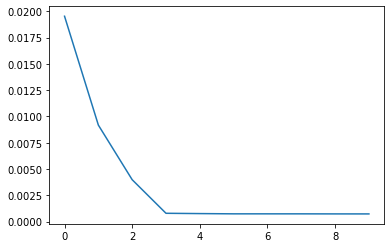

In [8]:
rnn = RNN(7, hidden_size = 10, num_rnns = 6, lr = 1e-3, bi = False)
ae = AE(rnn, dim = 7)
ae.train(10, padded_data, np.array(length))

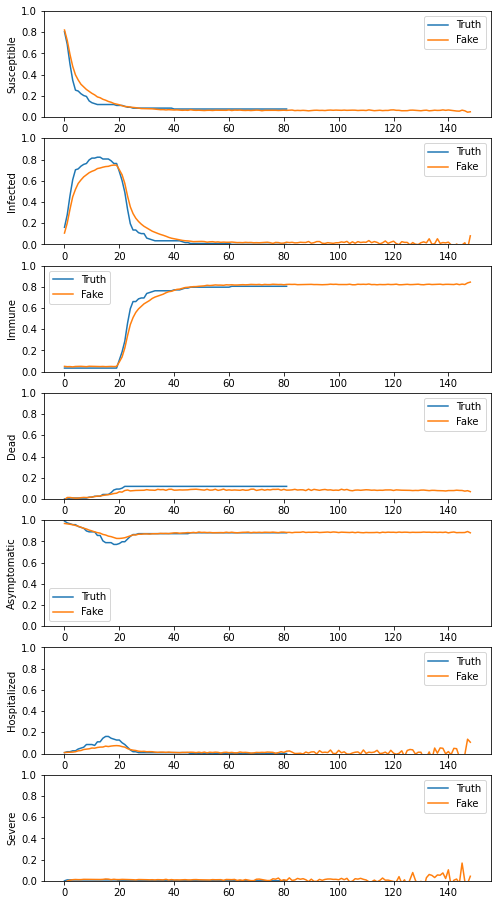

In [9]:
ae.inference(test_dat[np.random.randint(1000)])

Number of cINN parameters: 574560
Epoch: 1
Loss: 0.35672393894027055
Metric: [0.02003261 0.02469072 4.834795   4.922097   4.6508975 ]
Epoch: 2
Loss: 0.3021625087665587
Metric: [0.0195969  0.02522698 4.6924477  4.9761405  4.4669237 ]
Epoch: 3
Loss: 0.29527487971757405
Metric: [0.01961054 0.02477922 5.019496   5.1444464  4.2990723 ]
Epoch: 4
Loss: 0.2927411943147546
Metric: [0.01889323 0.02471953 4.708287   4.995306   4.4445305 ]
Epoch: 5
Loss: 0.291092599449225
Metric: [0.01996136 0.0250466  4.8732557  5.088877   4.4357567 ]
Epoch: 6
Loss: 0.28904978146401394
Metric: [0.01812223 0.02389926 4.756631   5.016091   4.485481  ]
Epoch: 7
Loss: 0.2860968726894459
Metric: [0.01942983 0.02398495 4.9103966  5.034629   4.5583973 ]
Epoch: 8
Loss: 0.282381556585905
Metric: [0.02037969 0.02348306 4.982746   5.0997486  4.4196687 ]
Epoch: 9
Loss: 0.2745273314916625
Metric: [0.01964542 0.0235294  4.8752294  5.1052423  4.328603  ]
Epoch: 10
Loss: 0.26587471971452875
Metric: [0.02020475 0.0247375  4.77193

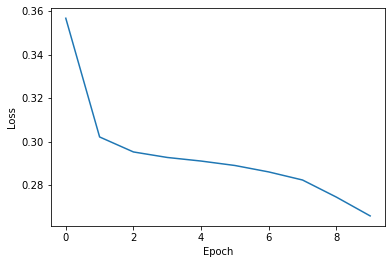

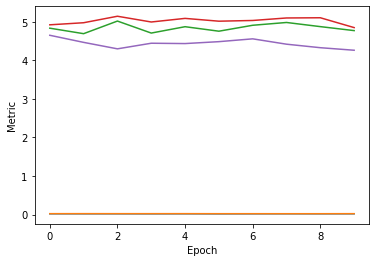

In [10]:
cinn = cINN(5, rnn.get_dim())
network = Estimator(rnn, cinn)
network.train(10, prepped, padded_data, np.array(length), batch_size = 1024, train_rnn = False)

Epoch: 1
Loss: 0.2870059275058468
Metric: [0.0190297  0.02322663 4.7482953  4.98388    4.4914465 ]
Epoch: 2
Loss: 0.26689862899561234
Metric: [0.01959557 0.02385945 4.839058   5.060568   4.4562697 ]
Epoch: 3
Loss: 0.2645785180924218
Metric: [0.01941064 0.02288185 4.81839    5.112851   4.599153  ]
Epoch: 4
Loss: 0.2617140898856175
Metric: [0.01966233 0.02301344 4.769349   5.0527153  4.3419266 ]
Epoch: 5
Loss: 0.26213516073808224
Metric: [0.02013038 0.02343896 5.10343    4.837446   4.4109535 ]
Epoch: 6
Loss: 0.2590434382218775
Metric: [0.02007116 0.02265813 4.8830585  5.043148   4.332389  ]
Epoch: 7
Loss: 0.2582704482777804
Metric: [0.01991588 0.02297552 4.8425283  4.9422665  4.5022163 ]
Epoch: 8
Loss: 0.2608271165365887
Metric: [0.01921502 0.02327021 4.7884655  5.179578   4.442904  ]
Epoch: 9
Loss: 0.25622657894456347
Metric: [0.0197244  0.02245258 4.9197426  5.0233936  4.452764  ]
Epoch: 10
Loss: 0.25612293368093547
Metric: [0.01979016 0.02262484 4.6362143  5.036271   4.431271  ]
Epoch

Epoch: 80
Loss: 0.22235141110083234
Metric: [0.01976793 0.02151106 4.9208183  5.118522   4.519458  ]
Epoch: 81
Loss: 0.2220045965257045
Metric: [0.0191734 0.0215166 5.010102  4.9915466 4.504882 ]
Epoch: 82
Loss: 0.22173467278480538
Metric: [0.0195456  0.01986157 4.777526   5.054055   4.4422174 ]
Epoch: 83
Loss: 0.22135750870401347
Metric: [0.01949775 0.02110494 4.9182487  5.1810246  4.3275285 ]
Epoch: 84
Loss: 0.22179984530374766
Metric: [0.01928492 0.01966606 4.9127817  4.9200735  4.5834093 ]
Epoch: 85
Loss: 0.2211865336229439
Metric: [0.0199188 0.0208593 4.8567977 5.063443  4.3259683]
Epoch: 86
Loss: 0.22116462575673232
Metric: [0.02002666 0.02038533 4.7064867  4.9861336  4.4078903 ]
Epoch: 87
Loss: 0.22086669215043953
Metric: [0.01961671 0.02178073 4.865358   5.0096383  4.496943  ]
Epoch: 88
Loss: 0.2208543755772256
Metric: [0.02004228 0.02066075 4.9408073  4.9964857  4.466385  ]
Epoch: 89
Loss: 0.22058427260115784
Metric: [0.0198694  0.02132322 4.7313766  4.975543   4.523925  ]
Epo

Epoch: 161
Loss: 0.21023827949176813
Metric: [0.01986768 0.02116477 4.761276   4.99031    4.349242  ]
Epoch: 162
Loss: 0.21018091581314272
Metric: [0.02004493 0.02108941 4.8544626  5.1426773  4.3294425 ]
Epoch: 163
Loss: 0.20991563976021616
Metric: [0.02001772 0.02031593 4.7306366  4.9270687  4.4171724 ]
Epoch: 164
Loss: 0.2098324618996665
Metric: [0.01990518 0.02120075 4.8549404  4.9967036  4.373161  ]
Epoch: 165
Loss: 0.20966783450264806
Metric: [0.01988538 0.02108208 4.6876073  4.9339123  4.36888   ]
Epoch: 166
Loss: 0.2100650824000895
Metric: [0.0199101  0.02120418 4.736267   5.0952325  4.3796062 ]
Epoch: 167
Loss: 0.2094214548070524
Metric: [0.01972695 0.02000749 4.832538   4.7748604  4.405326  ]
Epoch: 168
Loss: 0.2095744736203037
Metric: [0.01923163 0.02053313 4.7969036  5.0929327  4.433499  ]
Epoch: 169
Loss: 0.2092758905761233
Metric: [0.01976063 0.02078323 4.987523   4.959851   4.315485  ]
Epoch: 170
Loss: 0.2095888487652417
Metric: [0.01937469 0.02118868 4.8015     4.925958 

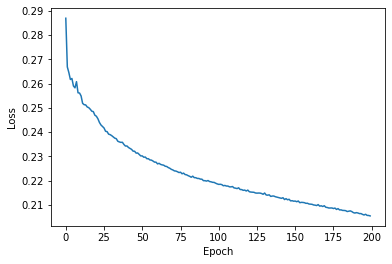

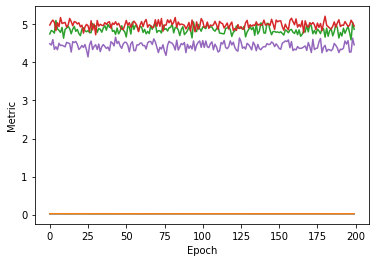

In [11]:
network.train(200, prepped, padded_data, np.array(length), batch_size = 1024, train_rnn = True)

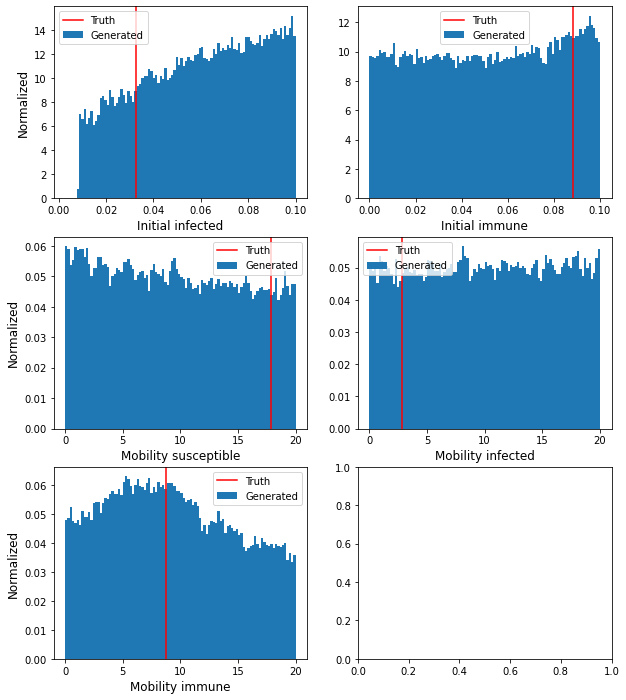

In [12]:
i = np.random.randint(len(test_dat))
network.inference(test_dat[i], test_params[i])

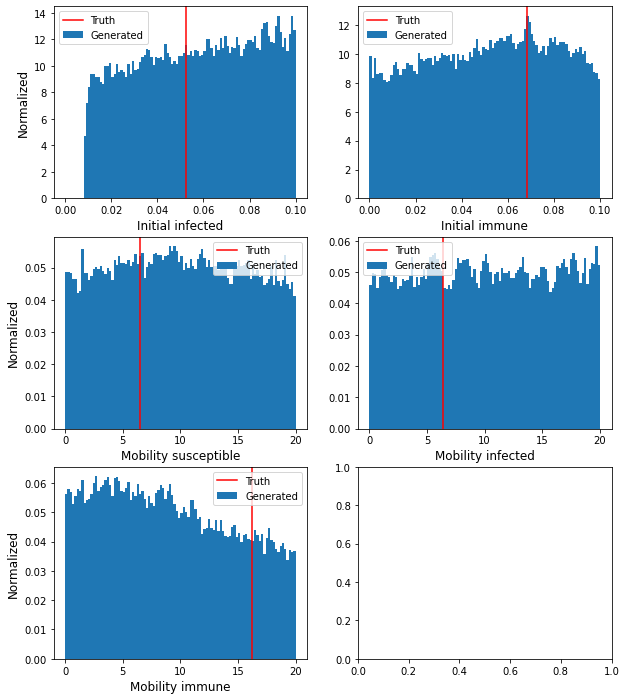

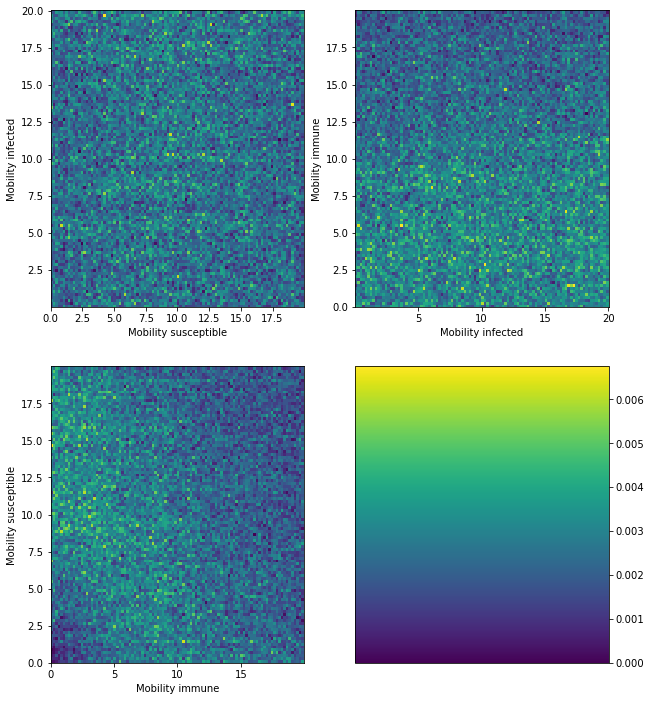

In [13]:
i = np.random.randint(len(test_dat))
network.inference(test_dat[i], test_params[i], twod = True)